In [1]:
!pip install nilearn==0.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 74.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
data_dir = '/content/drive/MyDrive/algonauts_2023_tutorial_data' #@param {type:"string"}
parent_submission_dir = '/content/drive/MyDrive/algonauts_2023_challenge_submission-02-alexnet' #@param {type:"string"}

Mounted at /content/drive/


In [3]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

In [4]:
device = 'cuda' #@param ['cpu', 'cuda'] {allow-input: true}
device = torch.device(device)
subj = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}

In [5]:

class argObj:
  def __init__(self, data_dir, parent_submission_dir, subj):

    self.subj = format(subj, '02')
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)
    self.parent_submission_dir = parent_submission_dir
    self.subject_submission_dir = os.path.join(self.parent_submission_dir,
        'subj'+self.subj)

    # Create the submission directory if not existing
    if not os.path.isdir(self.subject_submission_dir):
        os.makedirs(self.subject_submission_dir)


LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)
Training stimulus images: 8857

Validation stimulus images: 984

Test stimulus images: 159
Current cuda device:  cuda


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


100%|██████████| 1/1 [00:44<00:00, 44.72s/it]



Training images features:
(8857, 100)
(Training stimulus images × PCA features)

Validation images features:
(984, 100)
(Validation stimulus images × PCA features)

Test images features:
(984, 100)
(Test stimulus images × PCA features)


100%|██████████| 20544/20544 [00:25<00:00, 802.81it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


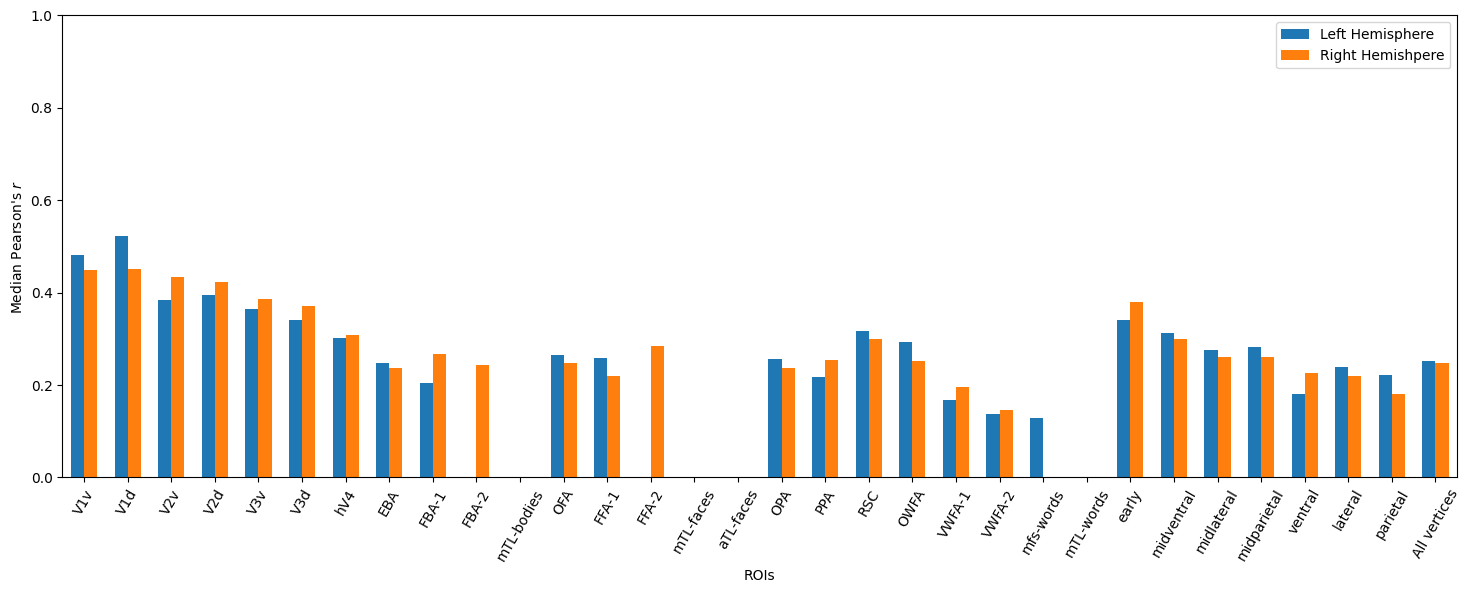

In [13]:

args = argObj(data_dir, parent_submission_dir, subj)

fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}
roi = "EBA" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
fsaverage_roi_class = np.load(roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)


# In[37]:


train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()



# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
challenge_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
fsaverage_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
challenge_roi_class = np.load(challenge_roi_class_dir)
fsaverage_roi_class = np.load(fsaverage_roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)


rand_seed = 5 #@param
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])


class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img


batch_size = 500 #@param
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform),
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform),
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform),
    batch_size=batch_size
)


lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]


del lh_fmri, rh_fmri


# 打印当前的cuda设备,如果没有cuda设备则使用cpu
print('Current cuda device: ', device)




model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it



train_nodes, _ = get_graph_node_names(model)
print(train_nodes)




model_layer = "features.12" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])



def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=500)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca




pca = fit_pca(feature_extractor, train_imgs_dataloader)



def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)



features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_val.shape)
print('(Test stimulus images × PCA features)')




del model, pca



# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)



# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]




hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the correlation results onto the brain surface map
fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_correlation
elif hemisphere == 'right':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_correlation




# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);



lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)



LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)
Training stimulus images: 8857

Validation stimulus images: 984

Test stimulus images: 159
Current cuda device:  cuda


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


100%|██████████| 1/1 [00:46<00:00, 46.48s/it]



Training images features:
(8857, 100)
(Training stimulus images × PCA features)

Validation images features:
(984, 100)
(Validation stimulus images × PCA features)

Test images features:
(984, 100)
(Test stimulus images × PCA features)


100%|██████████| 20544/20544 [00:26<00:00, 784.90it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


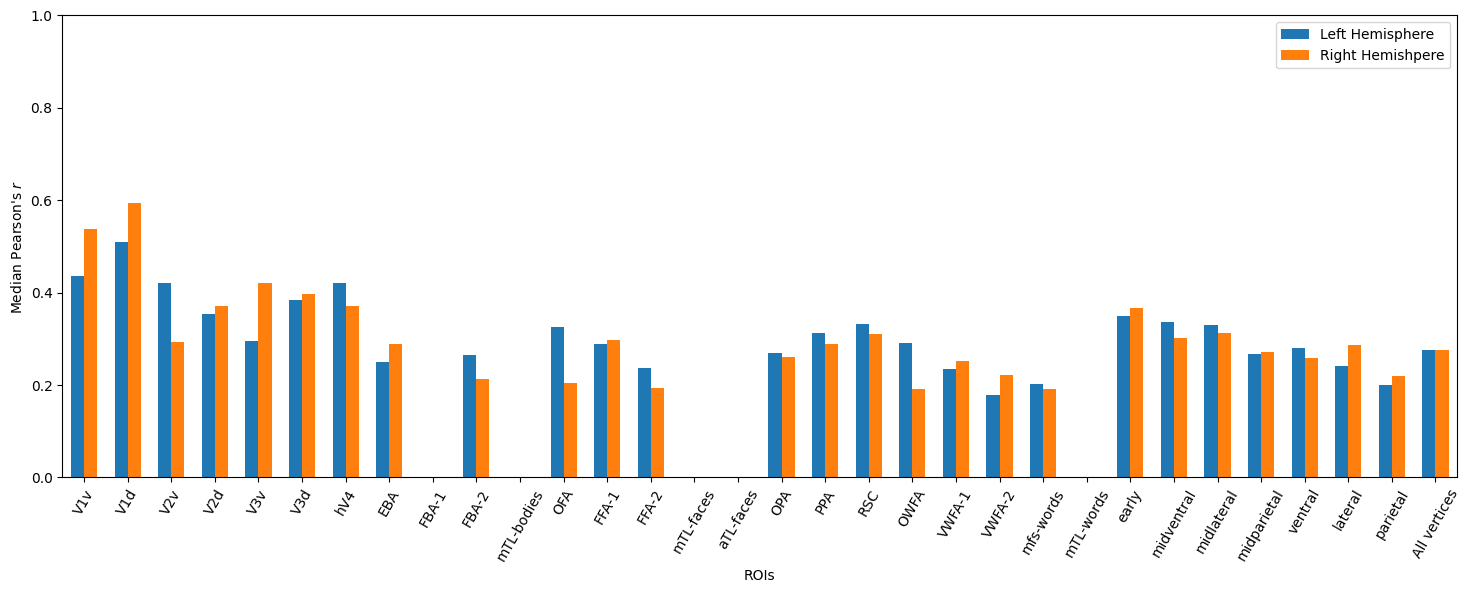

In [14]:
subj = 2

args = argObj(data_dir, parent_submission_dir, subj)

fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}
roi = "EBA" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
fsaverage_roi_class = np.load(roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)


# In[37]:


train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()



# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
challenge_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
fsaverage_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
challenge_roi_class = np.load(challenge_roi_class_dir)
fsaverage_roi_class = np.load(fsaverage_roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)


rand_seed = 5 #@param
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])


class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img


batch_size = 500 #@param
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform),
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform),
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform),
    batch_size=batch_size
)


lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]


del lh_fmri, rh_fmri


# 打印当前的cuda设备,如果没有cuda设备则使用cpu
print('Current cuda device: ', device)




model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it



train_nodes, _ = get_graph_node_names(model)
print(train_nodes)




model_layer = "features.12" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])



def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=500)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca




pca = fit_pca(feature_extractor, train_imgs_dataloader)



def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)



features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_val.shape)
print('(Test stimulus images × PCA features)')




del model, pca



# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)



# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]




hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the correlation results onto the brain surface map
fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_correlation
elif hemisphere == 'right':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_correlation




# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);



lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)



LH training fMRI data shape:
(9082, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9082, 20544)
(Training stimulus images × RH vertices)
Training stimulus images: 8174

Validation stimulus images: 908

Test stimulus images: 293
Current cuda device:  cuda


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


100%|██████████| 1/1 [01:06<00:00, 66.30s/it]



Training images features:
(8174, 100)
(Training stimulus images × PCA features)

Validation images features:
(908, 100)
(Validation stimulus images × PCA features)

Test images features:
(908, 100)
(Test stimulus images × PCA features)


100%|██████████| 20544/20544 [00:25<00:00, 794.50it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


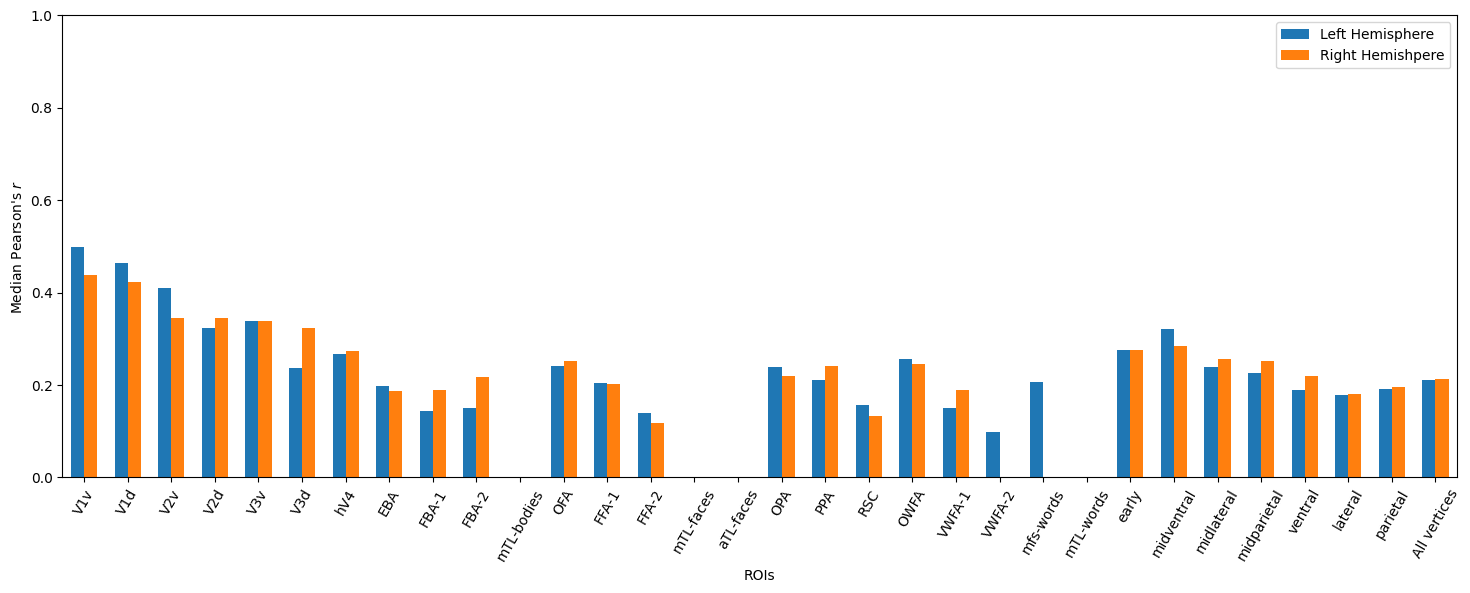

In [15]:
subj = 3

args = argObj(data_dir, parent_submission_dir, subj)

fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}
roi = "EBA" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
fsaverage_roi_class = np.load(roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()



# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
challenge_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
fsaverage_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
challenge_roi_class = np.load(challenge_roi_class_dir)
fsaverage_roi_class = np.load(fsaverage_roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)


rand_seed = 5 #@param
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])


class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img


batch_size = 500 #@param
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform),
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform),
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform),
    batch_size=batch_size
)


lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

del lh_fmri, rh_fmri

# 打印当前的cuda设备,如果没有cuda设备则使用cpu
print('Current cuda device: ', device)


model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it



train_nodes, _ = get_graph_node_names(model)
print(train_nodes)




model_layer = "features.12" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])



def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=500)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca




pca = fit_pca(feature_extractor, train_imgs_dataloader)



def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)



features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_val.shape)
print('(Test stimulus images × PCA features)')




del model, pca



# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)



# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]




hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the correlation results onto the brain surface map
fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_correlation
elif hemisphere == 'right':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_correlation




# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);



lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)



LH training fMRI data shape:
(8779, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(8779, 20544)
(Training stimulus images × RH vertices)
Training stimulus images: 7901

Validation stimulus images: 878

Test stimulus images: 395
Current cuda device:  cuda


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


100%|██████████| 1/1 [06:05<00:00, 365.36s/it]



Training images features:
(7901, 100)
(Training stimulus images × PCA features)

Validation images features:
(878, 100)
(Validation stimulus images × PCA features)

Test images features:
(878, 100)
(Test stimulus images × PCA features)


100%|██████████| 20544/20544 [00:27<00:00, 759.07it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


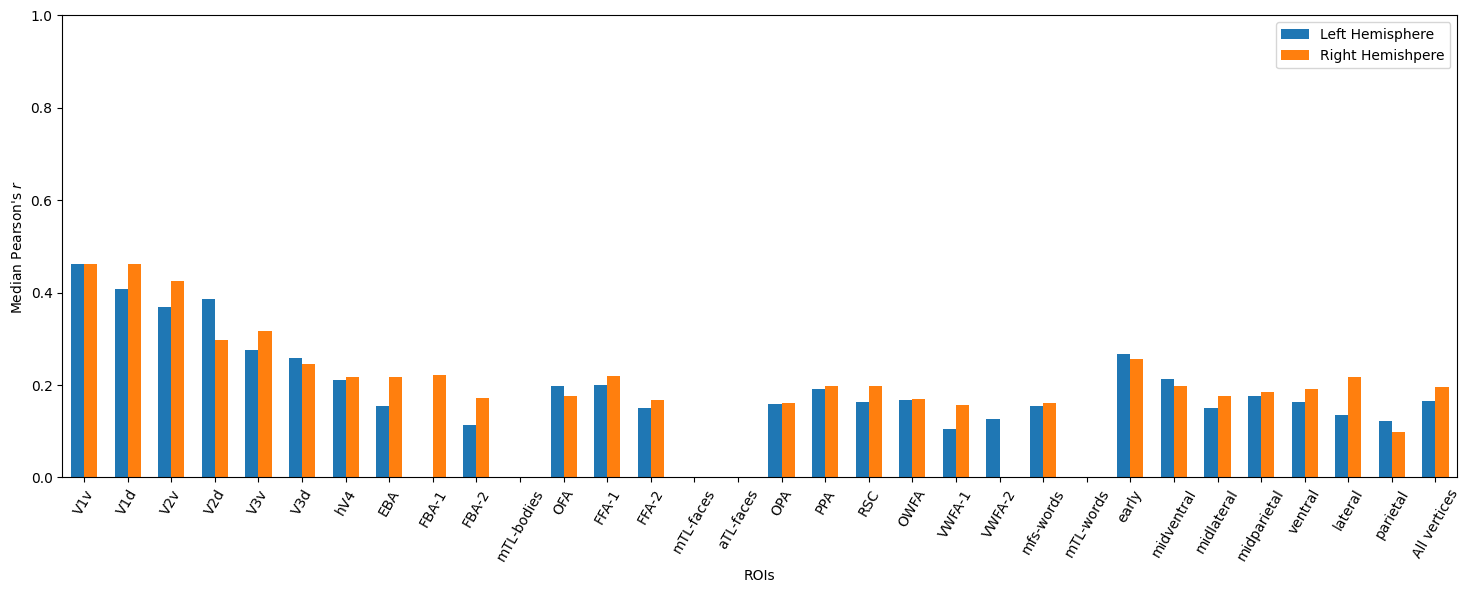

In [6]:
subj = 4

args = argObj(data_dir, parent_submission_dir, subj)

fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}
roi = "EBA" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
fsaverage_roi_class = np.load(roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()



# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
challenge_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
fsaverage_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
challenge_roi_class = np.load(challenge_roi_class_dir)
fsaverage_roi_class = np.load(fsaverage_roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)


rand_seed = 5 #@param
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])


class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img


batch_size = 500 #@param
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform),
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform),
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform),
    batch_size=batch_size
)


lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

del lh_fmri, rh_fmri

# 打印当前的cuda设备,如果没有cuda设备则使用cpu
print('Current cuda device: ', device)


model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it



train_nodes, _ = get_graph_node_names(model)
print(train_nodes)




model_layer = "features.12" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])



def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=500)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca




pca = fit_pca(feature_extractor, train_imgs_dataloader)



def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)



features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_val.shape)
print('(Test stimulus images × PCA features)')




del model, pca



# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)



# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]




hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the correlation results onto the brain surface map
fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_correlation
elif hemisphere == 'right':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_correlation




# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);



lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)



LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)
Training stimulus images: 8857

Validation stimulus images: 984

Test stimulus images: 159
Current cuda device:  cuda


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


100%|██████████| 1/1 [02:25<00:00, 145.32s/it]



Training images features:
(8857, 100)
(Training stimulus images × PCA features)

Validation images features:
(984, 100)
(Validation stimulus images × PCA features)

Test images features:
(984, 100)
(Test stimulus images × PCA features)


100%|██████████| 20544/20544 [00:26<00:00, 763.33it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


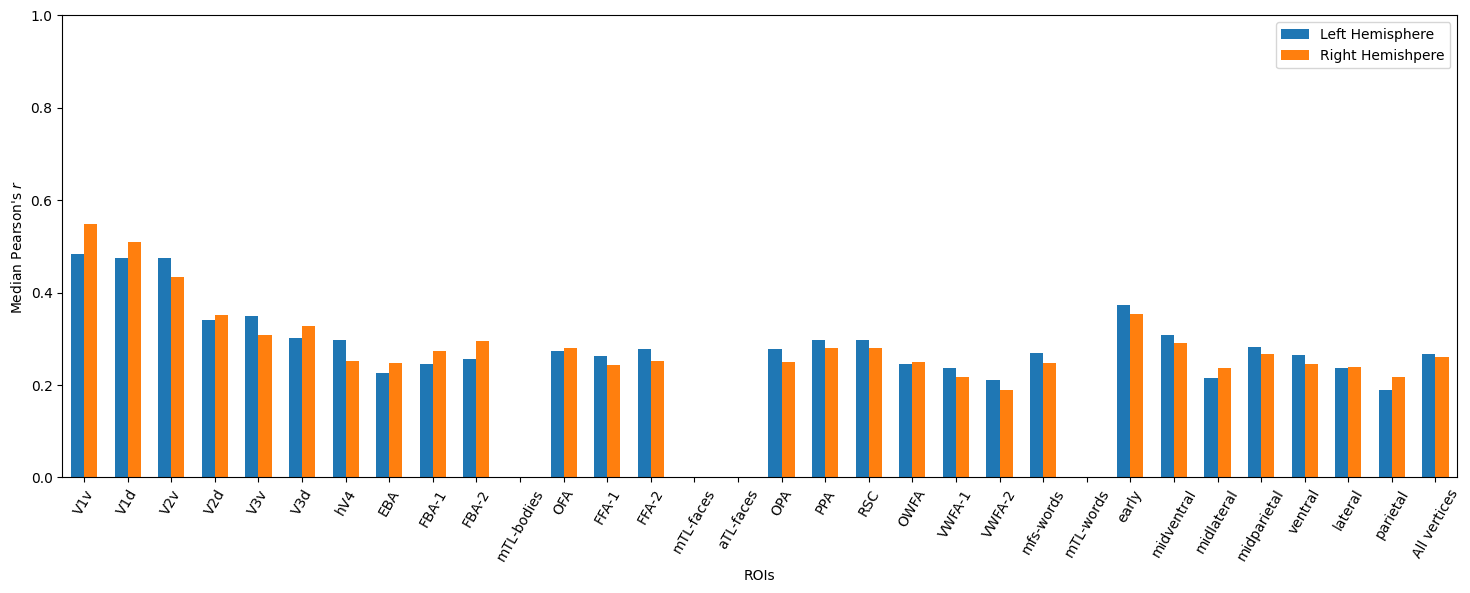

In [7]:
subj = 5

args = argObj(data_dir, parent_submission_dir, subj)

fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}
roi = "EBA" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
fsaverage_roi_class = np.load(roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()



# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
challenge_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
fsaverage_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
challenge_roi_class = np.load(challenge_roi_class_dir)
fsaverage_roi_class = np.load(fsaverage_roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)


rand_seed = 5 #@param
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])


class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img


batch_size = 500 #@param
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform),
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform),
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform),
    batch_size=batch_size
)


lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

del lh_fmri, rh_fmri

# 打印当前的cuda设备,如果没有cuda设备则使用cpu
print('Current cuda device: ', device)


model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it



train_nodes, _ = get_graph_node_names(model)
print(train_nodes)




model_layer = "features.12" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])



def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=500)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca




pca = fit_pca(feature_extractor, train_imgs_dataloader)



def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)



features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_val.shape)
print('(Test stimulus images × PCA features)')




del model, pca



# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)



# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]




hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the correlation results onto the brain surface map
fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_correlation
elif hemisphere == 'right':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_correlation




# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);



lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)



LH training fMRI data shape:
(9082, 18978)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9082, 20220)
(Training stimulus images × RH vertices)
Training stimulus images: 8174

Validation stimulus images: 908

Test stimulus images: 293
Current cuda device:  cuda


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


100%|██████████| 1/1 [04:28<00:00, 268.33s/it]



Training images features:
(8174, 100)
(Training stimulus images × PCA features)

Validation images features:
(908, 100)
(Validation stimulus images × PCA features)

Test images features:
(908, 100)
(Test stimulus images × PCA features)


100%|██████████| 20220/20220 [00:26<00:00, 757.53it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


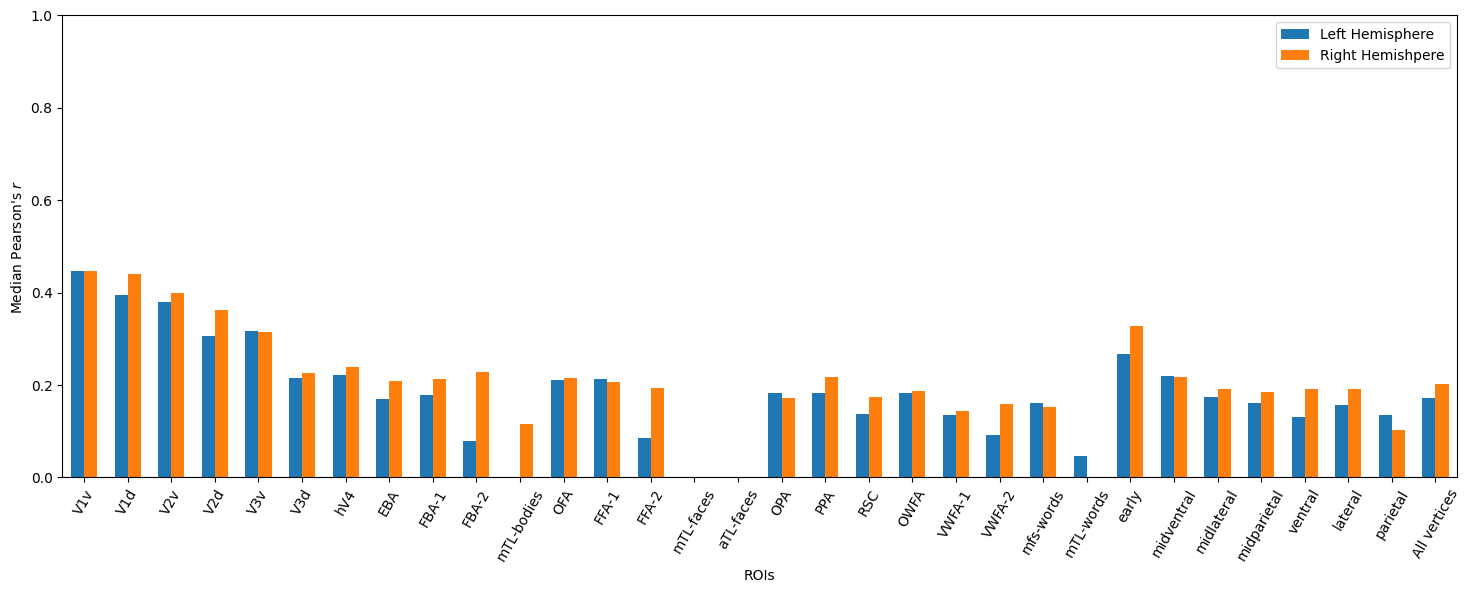

In [8]:
subj = 6

args = argObj(data_dir, parent_submission_dir, subj)

fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}
roi = "EBA" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
fsaverage_roi_class = np.load(roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()



# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
challenge_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
fsaverage_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
challenge_roi_class = np.load(challenge_roi_class_dir)
fsaverage_roi_class = np.load(fsaverage_roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)


rand_seed = 5 #@param
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])


class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img


batch_size = 500 #@param
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform),
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform),
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform),
    batch_size=batch_size
)


lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

del lh_fmri, rh_fmri

# 打印当前的cuda设备,如果没有cuda设备则使用cpu
print('Current cuda device: ', device)


model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it



train_nodes, _ = get_graph_node_names(model)
print(train_nodes)




model_layer = "features.12" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])



def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=500)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca




pca = fit_pca(feature_extractor, train_imgs_dataloader)



def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)



features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_val.shape)
print('(Test stimulus images × PCA features)')




del model, pca



# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)



# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]




hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the correlation results onto the brain surface map
fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_correlation
elif hemisphere == 'right':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_correlation




# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);



lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)



LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)
Training stimulus images: 8857

Validation stimulus images: 984

Test stimulus images: 159
Current cuda device:  cuda


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


100%|██████████| 1/1 [02:22<00:00, 142.42s/it]



Training images features:
(8857, 100)
(Training stimulus images × PCA features)

Validation images features:
(984, 100)
(Validation stimulus images × PCA features)

Test images features:
(984, 100)
(Test stimulus images × PCA features)


100%|██████████| 20544/20544 [00:27<00:00, 748.63it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


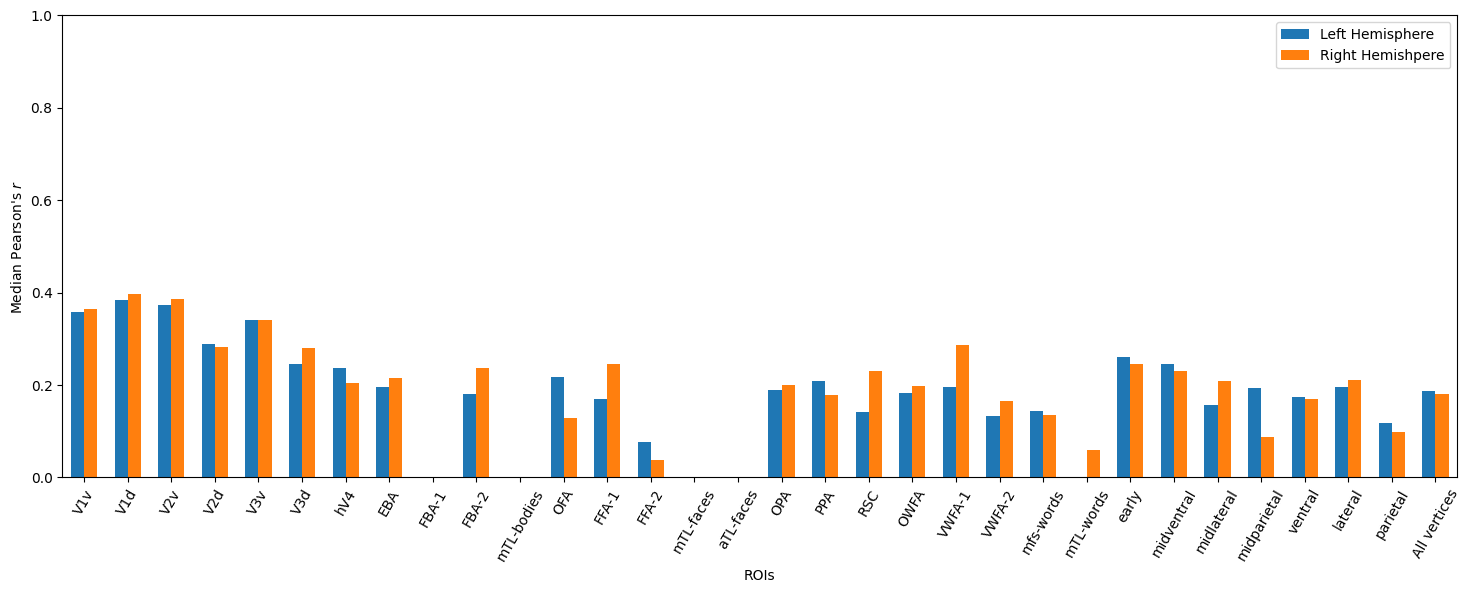

In [9]:
subj = 7

args = argObj(data_dir, parent_submission_dir, subj)

fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}
roi = "EBA" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
fsaverage_roi_class = np.load(roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()



# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
challenge_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
fsaverage_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
challenge_roi_class = np.load(challenge_roi_class_dir)
fsaverage_roi_class = np.load(fsaverage_roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)


rand_seed = 5 #@param
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])


class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img


batch_size = 500 #@param
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform),
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform),
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform),
    batch_size=batch_size
)


lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

del lh_fmri, rh_fmri

# 打印当前的cuda设备,如果没有cuda设备则使用cpu
print('Current cuda device: ', device)


model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it



train_nodes, _ = get_graph_node_names(model)
print(train_nodes)




model_layer = "features.12" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])



def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=500)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca




pca = fit_pca(feature_extractor, train_imgs_dataloader)



def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)



features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_val.shape)
print('(Test stimulus images × PCA features)')




del model, pca



# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)



# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]




hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the correlation results onto the brain surface map
fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_correlation
elif hemisphere == 'right':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_correlation




# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);



lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)



LH training fMRI data shape:
(8779, 18981)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(8779, 20530)
(Training stimulus images × RH vertices)
Training stimulus images: 7901

Validation stimulus images: 878

Test stimulus images: 395
Current cuda device:  cuda


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


100%|██████████| 1/1 [06:01<00:00, 361.60s/it]



Training images features:
(7901, 100)
(Training stimulus images × PCA features)

Validation images features:
(878, 100)
(Validation stimulus images × PCA features)

Test images features:
(878, 100)
(Test stimulus images × PCA features)


100%|██████████| 20530/20530 [00:26<00:00, 760.73it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


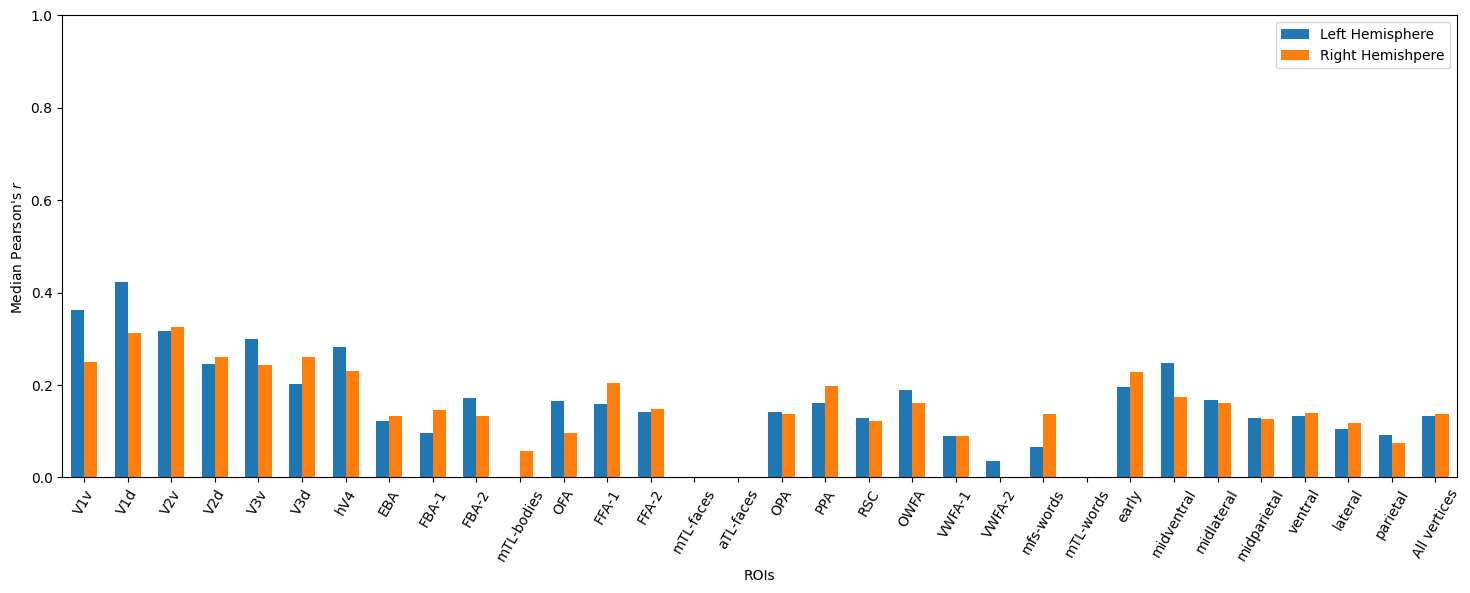

In [10]:
subj = 8

args = argObj(data_dir, parent_submission_dir, subj)

fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)


hemisphere = 'right' #@param ['left', 'right'] {allow-input: true}
roi = "EBA" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
fsaverage_roi_class = np.load(roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()



# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Define the ROI class based on the selected ROI
if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
    roi_class = 'prf-visualrois'
elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
    roi_class = 'floc-bodies'
elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
    roi_class = 'floc-faces'
elif roi in ["OPA", "PPA", "RSC"]:
    roi_class = 'floc-places'
elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
    roi_class = 'floc-words'
elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
    roi_class = 'streams'

# Load the ROI brain surface maps
challenge_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')
fsaverage_roi_class_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')
roi_map_dir = os.path.join(args.data_dir, 'roi_masks',
    'mapping_'+roi_class+'.npy')
challenge_roi_class = np.load(challenge_roi_class_dir)
fsaverage_roi_class = np.load(fsaverage_roi_class_dir)
roi_map = np.load(roi_map_dir, allow_pickle=True).item()

# Select the vertices corresponding to the ROI of interest
roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)


rand_seed = 5 #@param
np.random.seed(rand_seed)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(train_img_list) / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])


class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img


batch_size = 500 #@param
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform),
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform),
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform),
    batch_size=batch_size
)


lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

del lh_fmri, rh_fmri

# 打印当前的cuda设备,如果没有cuda设备则使用cpu
print('Current cuda device: ', device)


model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it



train_nodes, _ = get_graph_node_names(model)
print(train_nodes)




model_layer = "features.12" #@param ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])



def fit_pca(feature_extractor, dataloader):

    # Define PCA parameters
    pca = IncrementalPCA(n_components=100, batch_size=500)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca




pca = fit_pca(feature_extractor, train_imgs_dataloader)



def extract_features(feature_extractor, dataloader, pca):

    features = []
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Apply PCA transform
        ft = pca.transform(ft.cpu().detach().numpy())
        features.append(ft)
    return np.vstack(features)



features_train = extract_features(feature_extractor, train_imgs_dataloader, pca)
features_val = extract_features(feature_extractor, val_imgs_dataloader, pca)
features_test = extract_features(feature_extractor, test_imgs_dataloader, pca)

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × PCA features)')

print('\nValidation images features:')
print(features_val.shape)
print('(Validation stimulus images × PCA features)')

print('\nTest images features:')
print(features_val.shape)
print('(Test stimulus images × PCA features)')




del model, pca



# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)



# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]




hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

# Load the brain surface map of all vertices
roi_dir = os.path.join(args.data_dir, 'roi_masks',
    hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
fsaverage_all_vertices = np.load(roi_dir)

# Map the correlation results onto the brain surface map
fsaverage_correlation = np.zeros(len(fsaverage_all_vertices))
if hemisphere == 'left':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = lh_correlation
elif hemisphere == 'right':
    fsaverage_correlation[np.where(fsaverage_all_vertices)[0]] = rh_correlation




# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1);



lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

np.save(os.path.join(args.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
np.save(os.path.join(args.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)

